In [1]:
import os

import pyfesom2 as pf
import xarray as xr
import numpy as np
import shutil
import random
import string

import matplotlib.pyplot as plt
import cmocean
from matplotlib.patches import Circle

from matplotlib.colors import LinearSegmentedColormap
from matplotlib.colors import  BoundaryNorm
from matplotlib import colormaps

import functools

import dask
import dask.array as da
from dask.distributed import Client
dask.config.config.get('distributed').get('dashboard').update({'link':'{JUPYTERHUB_SERVICE_PREFIX}proxy/{port}/status'})

osgeo is not installed, conversion to Geo formats like Geotiff (fesom2GeoFormat) will not work.


In [2]:
reg_eeb = [95, 145, 76, 87.5]
reg_web = [-10, 95, 80, 87.5]

region = reg_eeb

# lonlims = np.array(region[0:2])
# latlims = np.array(region[2:4])
# lonlims,latlims = pf.ut.scalar_g2r(-90,90,90,lonlims,latlims)
# region[0:2] = lonlims
# region[2:4] = latlims

In [3]:
region

[95, 145, 76, 87.5]

In [4]:
ice_min=0.85

In [5]:
# Define your custom preprocessing function
def preprocess(ds,var,cyc=None,ice_min=0,ice_max=1,rad_min=0,rad_max=99999,region=None):
    # Filter the dataset
    if region:
        lon_min=region[0]
        lon_max=region[1]
        lat_min=region[2]
        lat_max=region[3]
    else:
        lon_min=-9999
        lon_max=9999
        lat_min=-9999
        lat_max=9999
        
    cyc_indexer = ds['cyc'] == cyc
    rad_indexer = (ds['rad'] >= rad_min) & (ds['rad'] <= rad_max)
    ice_indexer = (ds['ice_avg'] >= ice_min) & (ds['ice_avg'] <= ice_max)
    lon_indexer = (ds['lon'] >= lon_min) & (ds['lon'] <= lon_max)
    lat_indexer = (ds['lat'] >= lat_min) & (ds['lat'] <= lat_max)
    indexer = (cyc_indexer&rad_indexer&ice_indexer&lon_indexer&lat_indexer).compute()  # Compute the indexer
    ds = ds.where(indexer, drop=True)
    #ice_indexer = .compute()  # Compute the indexer
    #ds = ds.where(ice_indexer, drop=True)
    # Store the length of the 'ee' dimension as a new variable
    ds['num_eddies'] = len(ds['ee'])
    ds['sum'] = ds[var].sum(dim='ee')
    ds['square_sum'] = (ds[var]**2).sum(dim='ee')
    #drop the variables that have 'ee' dimension
    ds = ds.drop_vars(var)
    ds = ds.drop_vars('num')
    ## Calculate the mean along the 'ee' dimension
    ds = ds.mean(dim='ee')
    return ds

In [42]:
# Define your custom preprocessing function
def preprocess_ce(ds,var,ice_min):
    # Filter the dataset to include only entries where cyc == 1
    cyc_indexer = ((ds['cyc'] == 1)&(ds['ice_avg']>=ice_min)).compute()  # Compute the indexer
    ds = ds.where(cyc_indexer, drop=True)
    #ice_indexer = .compute()  # Compute the indexer
    #ds = ds.where(ice_indexer, drop=True)
    # Store the length of the 'ee' dimension as a new variable
    ds['num_eddies'] = len(ds['ee'])
    ds['sum'] = ds[var].sum(dim='ee')
    ds['square_sum'] = (ds[var]**2).sum(dim='ee')
    #drop the variables that have 'ee' dimension
    ds = ds.drop_vars(var)
    ds = ds.drop_vars('num')
    ## Calculate the mean along the 'ee' dimension
    ds = ds.mean(dim='ee')
    return ds

def preprocess_ae(ds,var,ice_min):
    # Filter the dataset to include only entries where cyc == 1
    cyc_indexer = ((ds['cyc'] == -1)&(ds['ice_avg']>=ice_min)).compute()  # Compute the indexer
    ds = ds.where(cyc_indexer, drop=True)
    # ice_indexer = (ds['ice_avg']>0.85).compute()  # Compute the indexer
    # ds = ds.where(ice_indexer, drop=True)    
    # Store the length of the 'ee' dimension as a new variable
    ds['num_eddies'] = len(ds['ee'])
    ds['sum'] = ds[var].sum(dim='ee')
    ds['square_sum'] = (ds[var]**2).sum(dim='ee')
    #drop the variables that have 'ee' dimension
    ds = ds.drop_vars(var)
    ds = ds.drop_vars('num')
    ## Calculate the mean along the 'ee' dimension
    ds = ds.mean(dim='ee')
    return ds

# Define your custom boundaries
def discrete_cmap(N, base_cmap=None):
    """Create an N-bin discrete colormap from the specified input map"""

    # Note that if base_cmap is a string or None, you can simply do
    #    return plt.cm.get_cmap(base_cmap, N)
    # The following works for string, None, or a colormap instance:

    #base = plt.cm.get_cmap(base_cmap)
    base = colormaps.get_cmap(base_cmap)
    color_list = base(np.linspace(0, 1, N))
    cmap_name = base.name + str(N)
    #return base.from_list(cmap_name, color_list, N)
    return LinearSegmentedColormap.from_list(cmap_name, color_list, N)

def limits_for_levels(number):
    if number == 0:
        return 0  # Handle special case

    # Find the order of magnitude of the number
    order_of_magnitude = np.floor(np.log10(np.abs(number)))
    # Calculate the adjustment factor
    adjustment_factor = 5 * (10 ** (order_of_magnitude - 1))
    # Round the number to the next larger factor of 5
    rounded_number = np.ceil(number / adjustment_factor) * adjustment_factor
    # Ensure the sign is preserved
    if number < 0:
        rounded_number *= -1
    # Round the result to appropriate decimal places based on order of magnitude
    decimal_places = max(0, -int(order_of_magnitude) + 1)  # Ensure at least one decimal place
    rounded_number = np.round(rounded_number, decimal_places)
    
    n = int(1+(20*rounded_number/(10**order_of_magnitude)))
    return rounded_number, n



In [6]:
def generate_random_string(length):
    # Define the characters to choose from
    characters = string.ascii_letters + string.digits  # You can add more characters if needed
    # Use random.choices to generate a list of random characters
    random_characters = random.choices(characters, k=length)
    # Join the characters into a string
    random_string = ''.join(random_characters)
    return random_string
#spawn a parallel cluster
n_cores = 10
mem_lim = str(int(100*np.floor(960/n_cores)))+'MB' #96GB total memory, set to MB (96000), divide by number of cores, then round to next 100
dask_dir = '/p/scratch/chhb19/mueller29/dask_dir/'+generate_random_string(10)
if os.path.exists(dask_dir):
    shutil.rmtree(dask_dir)
if 'client' in locals() or 'client' in globals():
    client.close()
client = Client(local_directory=dask_dir,n_workers=n_cores, threads_per_worker=1,memory_limit=mem_lim)
client.amm.start()
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /user/vasco.mueller_at_awi.de/cff6684dcd9d4f83a0eff658f7852431/proxy/8787/status,
Dashboard: /user/vasco.mueller_at_awi.de/cff6684dcd9d4f83a0eff658f7852431/proxy/8787/status,Workers: 10
Total threads: 10,Total memory: 89.41 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:34705,Workers: 10
Dashboard: /user/vasco.mueller_at_awi.de/cff6684dcd9d4f83a0eff658f7852431/proxy/8787/status,Total threads: 10
Started: Just now,Total memory: 89.41 GiB
Comm: tcp://127.0.0.1:45187,Total threads: 1
Dashboard: /user/vasco.mueller_at_awi.de/cff6684dcd9d4f83a0eff658f7852431/proxy/33871/status,Memory: 8.94 GiB
Nanny: tcp://127.0.0.1:43029,


In [7]:
plot_path  = '/p/home/jusers/mueller29/juwels/EPICA/plots/composites/'

In [8]:
reg_x = np.arange(-3.1,3.1,.1)
reg_y = np.arange(-3,3.1,.1)
X,Y = np.meshgrid(reg_x,reg_y)

In [9]:
vars=['a_ice','m_ice','fh','temp_100','temp_0']
units_dict={
    "fh": 'W',
    "temp_100": '°C',
    "temp_0": '°C',
    "a_ice": '%',
    "m_ice": 'cm'
}


In [8]:
var='temp_0'

In [9]:
test = xr.open_mfdataset('/p/scratch/chhb19/mueller29/composites/100m/'+var+'/composite_'+var+'_20150101.nc')

In [15]:
client.close()

In [69]:
ds_ae = xr.open_mfdataset('/p/scratch/chhb19/mueller29/composites/100m/'+var+'/composite_'+var+'*0101*.nc', preprocess=functools.partial(preprocess, var=var,ice_min=ice_min,cyc=-1), combine='nested', concat_dim='time', parallel=True)
ds_ce = xr.open_mfdataset('/p/scratch/chhb19/mueller29/composites/100m/'+var+'/composite_'+var+'*0101*.nc', preprocess=functools.partial(preprocess, var=var,ice_min=ice_min,cyc=1), combine='nested', concat_dim='time', parallel=True)


s_ae = ds_ae['sum'].sum(dim='time').values
s_ce = ds_ce['sum'].sum(dim='time').values
ss_ae = ds_ae['square_sum'].sum(dim='time').values
ss_ce = ds_ce['square_sum'].sum(dim='time').values
n_ae = ds_ae['num_eddies'].sum(dim='time').values
n_ce = ds_ce['num_eddies'].sum(dim='time').values

ae_mean = (s_ae/n_ae)
ce_mean = (s_ce/n_ce)

ae_std = np.sqrt(((ss_ae/n_ae)-ae_mean**2))
ce_std = np.sqrt(((ss_ce/n_ce)-ce_mean**2))

if var == 'a_ice' or var == 'm_ice':
    ae_mean *= 100
    ce_mean *= 100
    ae_std *= 100
    ce_std *= 100

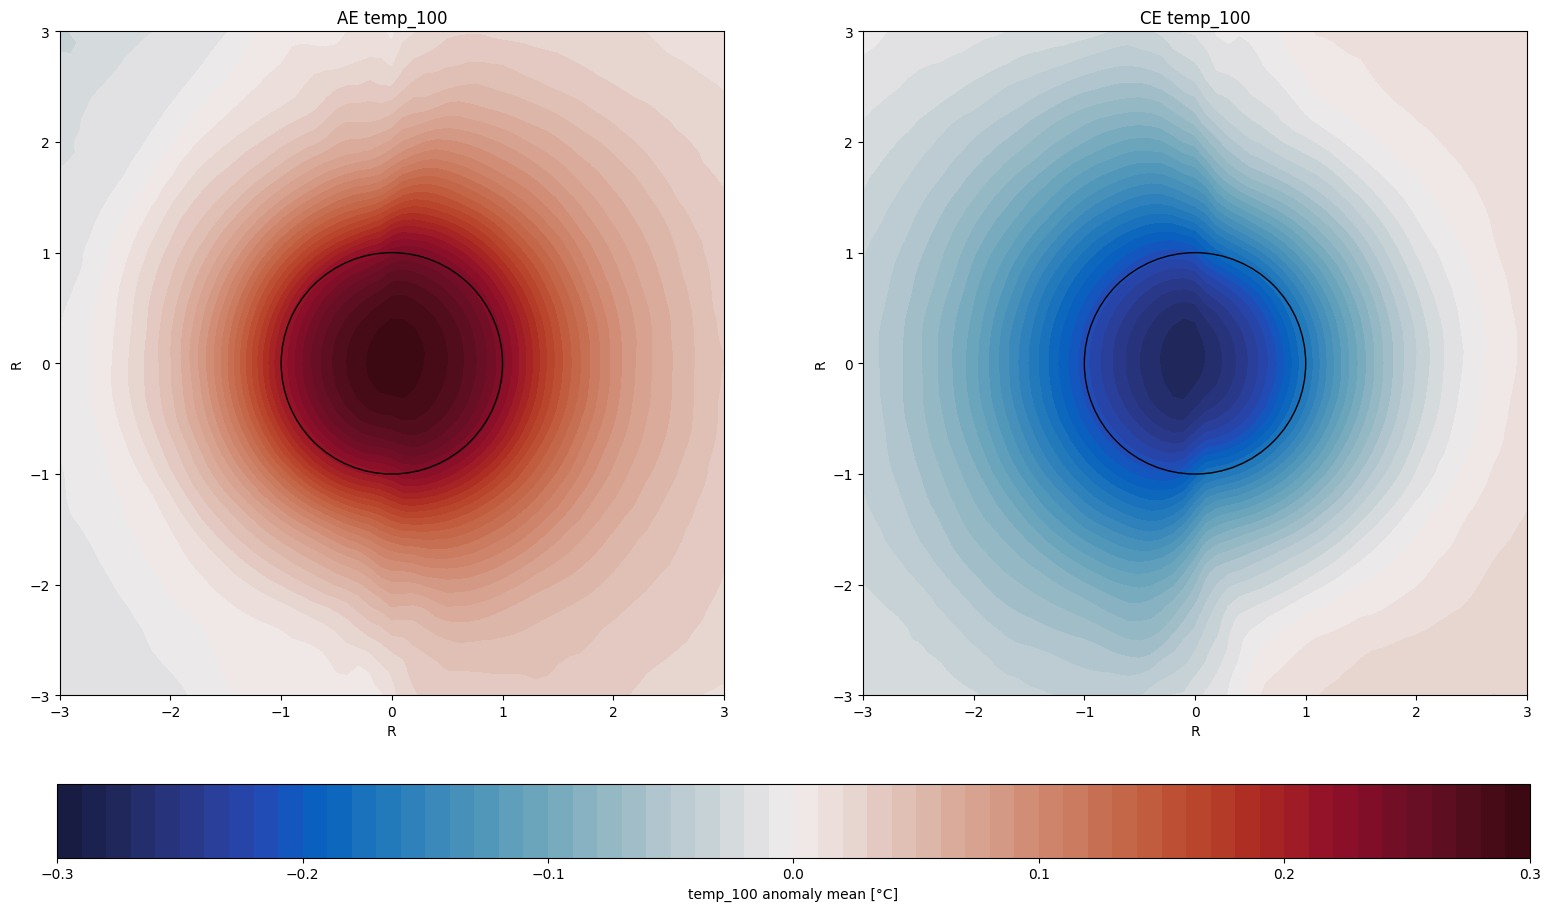

In [70]:
maxval,n = limits_for_levels(max([abs(ae_mean).max(),abs(ce_mean).max()]))

unit = units_dict.get(var)

bmin = -maxval
bmax = maxval
dstep = n

#bounds = np.arange(bmin,bmax+dstep,dstep).tolist()
bounds = np.linspace(bmin,bmax,dstep).tolist()

cmap = discrete_cmap(len(bounds)-1,cmocean.cm.balance)
norm = BoundaryNorm(bounds, cmap.N)



# Create a figure and axis
%matplotlib inline
figsize=(19,11.5)

fig, axs = plt.subplots(
            1,
            2,
            figsize=figsize,
        )

ax=axs[0]
pc=ax.contourf(X,Y,ae_mean,cmap=cmap, norm=norm,levels=bounds,extend='neither')
#ax.clabel(pc, fmt='%1.1f', inline=True, fontsize=10)

# Create a circle patch with center (x, y) and radius r
circle = Circle((0, 0), 1, edgecolor='k', facecolor='none')
# Add the circle patch to the axis
ax.add_patch(circle)

# Set aspect ratio to be equal to make the circle look like a circle
ax.set_aspect('equal', adjustable='box')
ax.set_title('AE '+var)

# Set limits for the plot
ax.set_xlim(-3, 3)
ax.set_ylim(-3, 3)
ax.set_xlabel('R')
ax.set_ylabel('R')

ax=axs[1]
pc=ax.contourf(X,Y,ce_mean,cmap=cmap, norm=norm,levels=bounds,extend='neither')
#ax.clabel(pc, fmt='%1.1f', inline=True, fontsize=10)

# Create a circle patch with center (x, y) and radius r
circle = Circle((0, 0), 1, edgecolor='k', facecolor='none')
# Add the circle patch to the axis
ax.add_patch(circle)

# Set aspect ratio to be equal to make the circle look like a circle
ax.set_aspect('equal', adjustable='box')
ax.set_title('CE '+var)

# Set limits for the plot
ax.set_xlim(-3, 3)
ax.set_ylim(-3, 3)
ax.set_xlabel('R')
ax.set_ylabel('R')

#colorbar
cbar=plt.colorbar(pc,ax=axs,orientation="horizontal", pad=.1,extend='neither')
cbar.ax.set_xscale('linear')
cbar.set_label(var+' anomaly mean ['+unit+']')

# Show the plot
plt.show()
#fig.savefig(plot_path + 'composite_'+var+'.png', dpi=600, format='png',bbox_inches='tight')

In [ ]:
a=1

In [ ]:
maxval,n = limits_for_levels(max([abs(ae_std).max(),abs(ce_std).max()]))

unit = units_dict.get(var)

bmin = 0
bmax = maxval
dstep = int(n-((n-1)/2))

#bounds = np.arange(bmin,bmax+dstep,dstep).tolist()
bounds = np.linspace(bmin,bmax,dstep).tolist()

cmap = discrete_cmap(len(bounds)-1,cmocean.cm.amp)
norm = BoundaryNorm(bounds, cmap.N)


# Create a figure and axis
%matplotlib inline
figsize=(19,11.5)

fig, axs = plt.subplots(
            1,
            2,
            figsize=figsize,
        )

ax=axs[0]
pc=ax.contourf(X,Y,ae_std,cmap=cmap, norm=norm,levels=bounds,extend='neither')

# Create a circle patch with center (x, y) and radius r
circle = Circle((0, 0), 1, edgecolor='k', facecolor='none')
# Add the circle patch to the axis
ax.add_patch(circle)

# Set aspect ratio to be equal to make the circle look like a circle
ax.set_aspect('equal', adjustable='box')
ax.set_title('AE '+var)

# Set limits for the plot
ax.set_xlim(-3, 3)
ax.set_ylim(-3, 3)
ax.set_xlabel('R')
ax.set_ylabel('R')

ax=axs[1]
pc=ax.contourf(X,Y,ce_std,cmap=cmap, norm=norm,levels=bounds,extend='neither')

# Create a circle patch with center (x, y) and radius r
circle = Circle((0, 0), 1, edgecolor='k', facecolor='none')
# Add the circle patch to the axis
ax.add_patch(circle)

# Set aspect ratio to be equal to make the circle look like a circle
ax.set_aspect('equal', adjustable='box')
ax.set_title('CE '+var)

# Set limits for the plot
ax.set_xlim(-3, 3)
ax.set_ylim(-3, 3)
ax.set_xlabel('R')
ax.set_ylabel('R')

#colorbar
cbar=plt.colorbar(pc,ax=axs,orientation="horizontal", pad=.1,extend='neither')
cbar.ax.set_xscale('linear')
cbar.set_label(var+' anomaly std. ['+unit+']')

# Show the plot
plt.show()
fig.savefig(plot_path + 'std_'+var+'.png', dpi=600, format='png',bbox_inches='tight')

In [ ]:
#client.close()